In [97]:
import numpy as np
from datetime import datetime as dt
from PIL import Image
import os
import csv
import cv2
from tensorflow.keras.models import Model, load_model
from train import preprocess, dice
from submission import run_length_enc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
original_width = 580
original_height = 420
img_width = 128
img_height = 128

In [160]:
print("loading test images")
test_path = "ultrasound-nerve-segmentation/test/"
train_path = "ultrasound-nerve-segmentation/train/"
files = os.listdir(test_path)
image_names = []
for f in files:
    if '_mask' not in f:
        image_names.append(os.path.splitext(f)[0])  
# train_names, test_names = train_test_split(image_names, test_size=0.1)
test_names = image_names
test_imgs = []
for f in test_names:
    if "_mask" not in f:
        im = Image.open(test_path+f+".tif")
        # TODO: try chaning this to cv2.resize and see?
        im_arr = np.asarray(im.resize((img_width, img_height)))
        test_imgs.append(im_arr)
mean = np.mean(test_imgs)
std = np.std(test_imgs)
test_imgs -= mean
test_imgs /= std
test_imgs = np.expand_dims(np.array(test_imgs, dtype='float32'), axis=3)

loading test images


In [161]:
print("loading model and predicting")
# load model and predict on images
model = load_model('model_weights.hd5', compile=False)
img_masks = model.predict(test_imgs, batch_size=256, verbose=1)

loading model and predicting
5508/5508 [==============================] - 470s 85ms/sample


In [164]:
# resize
masks_resized = np.zeros((img_masks.shape[0], original_height, original_width))
for i in range(img_masks.shape[0]):
    im_resized = np.array(cv2.resize(img_masks[i], (original_width, original_height)))
    masks_resized[i] = im_resized

In [156]:
print("Loading ground truth")
# load ground truth masks for these images
labels = np.zeros((len(test_names), original_height, original_width))
for i in range(len(test_names)):
    im = Image.open("ultrasound-nerve-segmentation/train/"+test_names[i]+ "_mask.tif")
    labels[i] = np.array(im)

Loading ground truth


In [66]:
# get dice between ground truth and predicted
d = dice(labels, masks_resized)

In [67]:
import tensorflow as tf
print(tf.Session().run(d))

1.4149913388990185


In [167]:
labels.shape
# # plt.subplot(521)
counter = 0
l = len(masks_resized)
print(l)
for i in masks_resized:
    if np.all(i<0.5):
        counter += 1
print(counter)
print(counter / l)

5508
4292
0.7792302106027597


In [102]:
#TODO: run length encode the masks, 
# then decode them, then view the decoding
# then see if the decoding matches the unencoded masks
encoded = run_length_enc(masks_resized[510])
print(encoded)

126560 20 126593 30 126980 20 127013 30 127400 20 127433 30 127820 20 127853 30 128240 20 128273 30 128654 92 129074 92 129494 92 129914 92 130331 108 130751 108 131171 108 131591 108 132011 108 132431 118 132851 118 133271 118 133691 118 134111 128 134531 128 134951 128 135371 128 135791 128 136207 138 136627 138 137047 138 137467 138 137887 138 138307 141 138727 141 139147 141 139567 141 139987 145 140407 145 140827 145 141247 145 141667 145 142087 145 142507 145 142927 145 143347 145 143771 144 144191 144 144611 144 145031 144 145451 144 145871 144 146291 144 146711 144 147131 144 147551 144 147971 144 148391 144 148811 144 149231 144 149654 138 150074 138 150494 138 150914 138 151340 128 151760 128 152180 128 152600 128 153020 128 153450 118 153870 118 154290 118 154710 118 155157 85 155577 85 155997 85 156417 85 156837 85 157280 45 157700 45 158120 45 158540 45


126560
126593
126980
127013
127400
127433
127820
127853
128240
128273
128654
129074
129494
129914
130331
130751
131171
131591
132011
132431
132851
133271
133691
134111
134531
134951
135371
135791
136207
136627
137047
137467
137887
138307
138727
139147
139567
139987
140407
140827
141247
141667
142087
142507
142927
143347
143771
144191
144611
145031
145451
145871
146291
146711
147131
147551
147971
148391
148811
149231
149654
150074
150494
150914
151340
151760
152180
152600
153020
153450
153870
154290
154710
155157
155577
155997
156417
156837
157280
157700
158120
158540


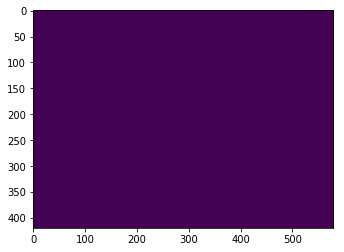

In [116]:
res = np.zeros((420, 580))
enc_list = encoded.split(" ")
for i in range(0,len(enc_list),2):
    print(enc_list[i])
    for j in range(int(enc_list[i]), int(enc_list[i+1])):
        print(j)
